In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time
import shutil
import re
import pretty_midi
from mido import MidiFile
import librosa
import IPython
from params import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from Dataset import get_dataloader
from Model import SKModel
from sklearn.linear_model import SGDRegressor, Perceptron
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.backend_bases as mpl

import torch
import torchaudio
%matplotlib widget

%load_ext autoreload
%autoreload 2

# Looking at our data

### Metadata

In [2]:
mid = pretty_midi.PrettyMIDI('data/musicnet_midis/Schubert/1727_schubert_op114_2.mid')
mid.instruments

[Instrument(program=40, is_drum=False, name="Violin"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Contrabass"),
 Instrument(program=0, is_drum=False, name="Pianoforte")]

In [3]:
meta = pd.read_csv(r"data\musicnet_metadata.csv")
meta.head(3)

,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1728,Schubert,Piano Quintet in A major,3. Scherzo: Presto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,251
2,1729,Schubert,Piano Quintet in A major,4. Andantino - Allegretto,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,444


In [4]:
meta = meta.drop(columns=["composition","movement", "ensemble", "source", "transcriber", "catalog_name"])
meta.head(5)

,id,composer,seconds
0,1727,Schubert,447
1,1728,Schubert,251
2,1729,Schubert,444
3,1730,Schubert,368
4,1733,Schubert,546


In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        330 non-null    int64 
 1   composer  330 non-null    object
 2   seconds   330 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ KB


### Sound files

AudioMetaData(sample_rate=44100, num_frames=19715328, num_channels=1, bits_per_sample=32, encoding=PCM_F)
number of features: 19715328


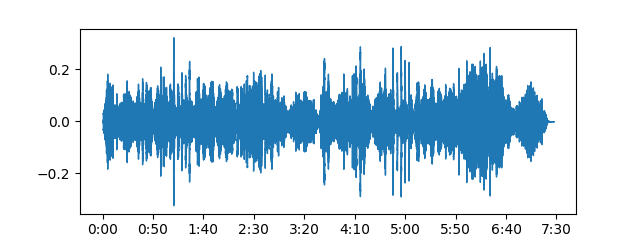

In [6]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH)

print(torchaudio.info(AUDIO_EXAMPLE_PATH))
print("number of features: {}".format(len(samples1[0])))

fig, ax1 = plt.subplots(1,figsize=(6.4,2.4))
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1)
plt.show()


We take only a sample of the initial audio file and reduce the sampling rate to get a dramatic decrease in number of features

number of features 1: 220500, number of features 2: 40000


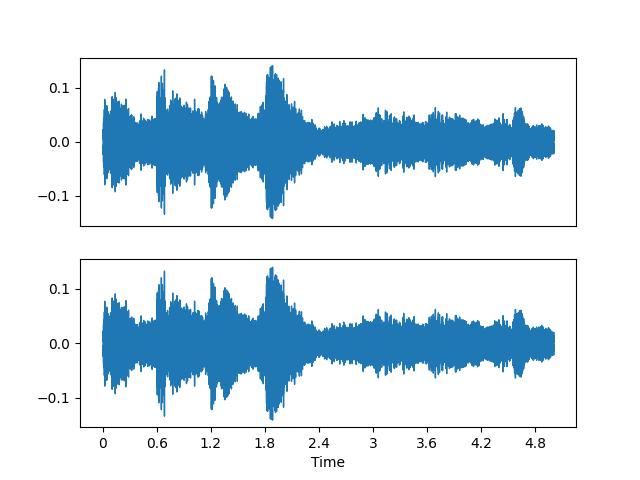

In [7]:
#Sample from second 8
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

print("number of features 1: {}, number of features 2: {}".format(len(samples1[0]),len(samples2[0])))

fig, (ax1,ax2) = plt.subplots(2,1)
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1,axis=None)
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=ax2)

In [8]:
IPython.display.display(IPython.display.Audio(samples1,rate=sr1))
IPython.display.display(IPython.display.Audio(samples2,rate=SAMPLING_RATE))


We lose some audio quality but really not that much!

# Creating our dataset

run this cell once

In [9]:
#Move the files to the desired directory
def create_dataset(df:pd.DataFrame):
    samples = {sample[:-4]:"train" for sample in  os.listdir('data/musicnet/train_data')}
    samples.update({sample[:-4]:"test" for sample in  os.listdir('data/musicnet/test_data')})
    
    instrument_data = []
    
    for path in glob.glob('data/musicnet_midis/*/*.mid'):
        id = re.sub("_.*","",os.path.basename(path))
        if id in samples:
            #keep only samples where we can access the midi file
            try: 
                mid = pretty_midi.PrettyMIDI(path)

                #load and save wav files as tensors
                sample_data,sr = torchaudio.load(f"data/musicnet/{samples[id]}_data/{id}.wav")
                sample_data = torchaudio.functional.resample(sample_data,sr,SAMPLING_RATE)
                torch.save(sample_data,f'data\{samples[id]}\{id}.pt')


                #Create instrument labels
                label = {"id":int(id), "path":f'data\{samples[id]}\{id}.pt', "train":samples[id]=="train"}
                label.update({instrument.program:1 for instrument in  mid.instruments})
                instrument_data.append(label)

            #remove "bad" samples
            except:
                print(f"could not load file: {path}")
                shutil.move(f"data/musicnet/{samples[id]}_data/{id}.wav",f"data/bad_data/{samples[id]}_data/{id}.wav")

    instrument_df = pd.DataFrame.from_records(instrument_data)
    return df.merge(instrument_df, on="id",how="right")

#Create the new metadata only if it doesnt exists
if os.path.exists(RAW_LABELS_CSV_DIR) == False:
    df = create_dataset(meta)
    df.to_csv(RAW_LABELS_CSV_DIR,index=False)

df = pd.read_csv(RAW_LABELS_CSV_DIR)

## Data labeling

In [10]:
df = df[df["train"]]
df = df.drop(columns="train").reset_index(drop=True)
df.head(5)

,id,composer,seconds,path,40,41,0,73,42,6,45,71,70,60,68,43
0,2186,Bach,214,data\train\2186.pt,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2195,Bach,155,data\train\2195.pt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2196,Bach,75,data\train\2196.pt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2198,Bach,197,data\train\2198.pt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2200,Bach,113,data\train\2200.pt,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


setting NaN values to 0

In [11]:
FIRST_COLS = ["id", "composer", "seconds", "path"]
def populate_dataset(df:pd.DataFrame):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    df = df.fillna(0)
    df = df.loc[:,  FIRST_COLS + numerical_cols]
    df = df.set_index("id")
    
    return df 

df = populate_dataset(df)
df.head(5)

,composer,seconds,path,0,40,41,42,43,45,6,60,68,70,71,73
id,,,,,,,,,,,,,,,
2186,Bach,214,data\train\2186.pt,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2195,Bach,155,data\train\2195.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2196,Bach,75,data\train\2196.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2198,Bach,197,data\train\2198.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200,Bach,113,data\train\2200.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
def plot_data_dis(df,fig,ax1,ax2):
    def onPick(event:mpl.PickEvent):
        this_block = event.artist
        numerical_cols = list(df.columns.difference(FIRST_COLS))
        num = int(np.rint(event.mouseevent.xdata))

        if event.mouseevent.button != 1:
            return
        end = False
        patches = ax1.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                end = True
        if end:
            return
        
        if num in range(len(numerical_cols)):
            
            x = (df[numerical_cols].sum()*0+1).cumsum()-1
            y = df[numerical_cols][df[numerical_cols[num]] == 1].sum()
            
            idx = y > 0
            info = ["{}\n{:.2%}".format(y[i],y[i]/df[numerical_cols].sum()[i]) for i in idx[idx].index ]
            p = ax1.bar(x[idx],y[idx],label=numerical_cols[num],picker=5)
            ax1.bar_label(p,label_type='center',labels=info,picker=5)

        
    
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    x = [i for i in range(len(numerical_cols))]
    y = df[numerical_cols].sum()
    p = ax1.bar(x, y,picker=True)
    ax1.bar_label(p,fmt=lambda h: "{}\n{:.2%}".format(int(h),h/len(df)))

    ax1.set_xticks(x)
    ax1.set_xticklabels(y.index)
    ax1.set_title("Instrument occurrences")
    ax1.set_ylabel("# Samples")
    ax1.set_xlabel("Instrument number")

    


    
    x = [i for i in range(len(df.composer.unique()))]
    y = df.composer.value_counts()
    ax2.bar(x, y)
    for i, h in enumerate(y):
        ax2.text(i,h,h, horizontalalignment='center',va='bottom')
    x_labels = y.index
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_labels)
    ax2.set_ylabel("# Samples")
    ax2.set_xlabel("Composer")

    
    fig.canvas.mpl_connect('pick_event',onPick)
    return ax1,ax2



Try clicking on instruments

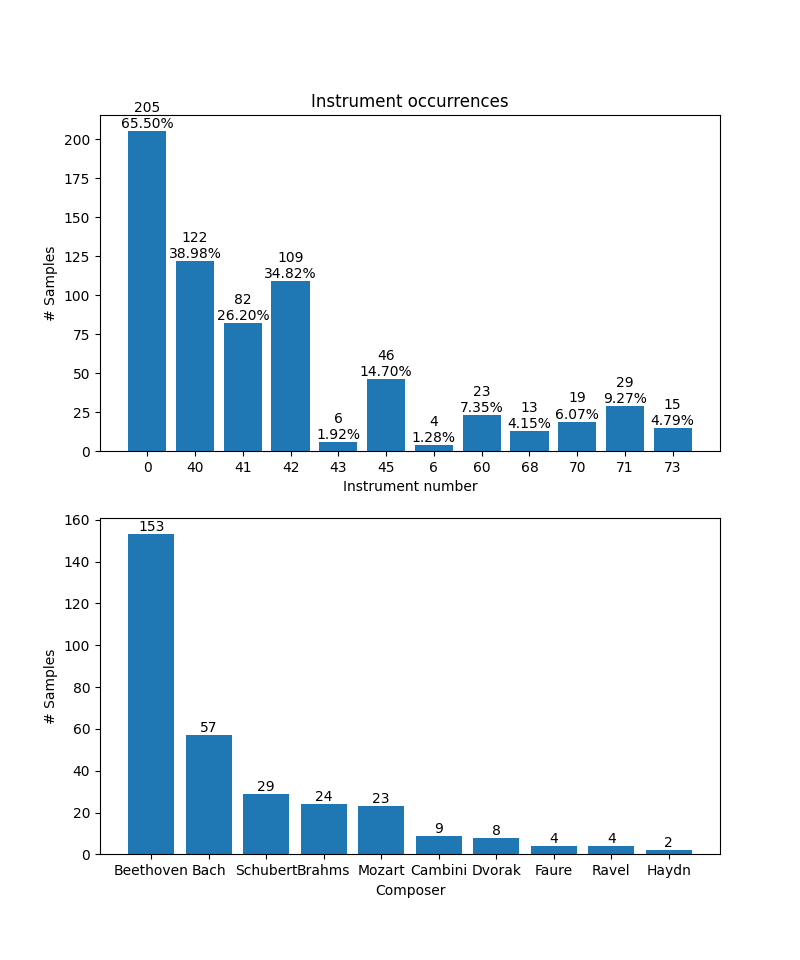

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)

### Cleaning Data

Removing labels that have a low amount of samples

In [25]:
def remove_outliers(df,min_instrument=10, min_composer=5, iters=5):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    drop_composers = []
    for _ in range(iters):
        mask = (df[numerical_cols].sum() < min_instrument) &  (df[numerical_cols].sum() != 0)
        drop1 = mask[mask==True].index
        for i in drop1:
            df = df[df[i]!=1]

        mask = (df.composer.value_counts()<min_composer)
        drop2 = mask[mask==True].index
        
        if len(drop1)==0 and len(drop2)==0: 
            break

        for i in drop2:
            df = df[df["composer"] != i]
            drop_composers.append(i)

    
    mask = (df[numerical_cols].sum() == 0) 
    drop_instruments = mask[mask==True].index
    df = df.drop(columns=drop_instruments)
    return df, drop_instruments, drop_composers

Setting a hard limit on the number of samples in the dataset

Note: during training and testing each one label may correspond to multiple samples from the same audio file

In [26]:
def drop_excess_samples(df):
    while df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES > 0:
        composer_samples = df[df['composer']==df['composer'].value_counts().idxmax()]
        n = df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES
        df = df.drop(index=composer_samples.sample(n).index)
    return df

Ensure we have the same number of composers for a more accurate evaluation

In [27]:
def balance_composers(df):
    max_samples = MAX_COMPOSER_SAMPLES
    temp = df['composer'].value_counts() < max_samples
    for comp in temp.index:
        n = max_samples-df['composer'].value_counts()[comp]
        if n > 0:
            composer_samples = df[df['composer']==comp]
            df = pd.concat([df, composer_samples.sample(n,replace=True)])
    return df

In [28]:
df, drop_instruments, drop_composers = remove_outliers(df)
df = drop_excess_samples(df)
df = balance_composers(df)
df

,composer,seconds,path,0,40,41,42,45,60,68,70,71,73
id,,,,,,,,,,,,,
2186,Bach,214,data\train\2186.pt,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2195,Bach,155,data\train\2195.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2196,Bach,75,data\train\2196.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2198,Bach,197,data\train\2198.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200,Bach,113,data\train\2200.pt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,Dvorak,250,data\train\1932.pt,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1916,Dvorak,675,data\train\1916.pt,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1932,Dvorak,250,data\train\1932.pt,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


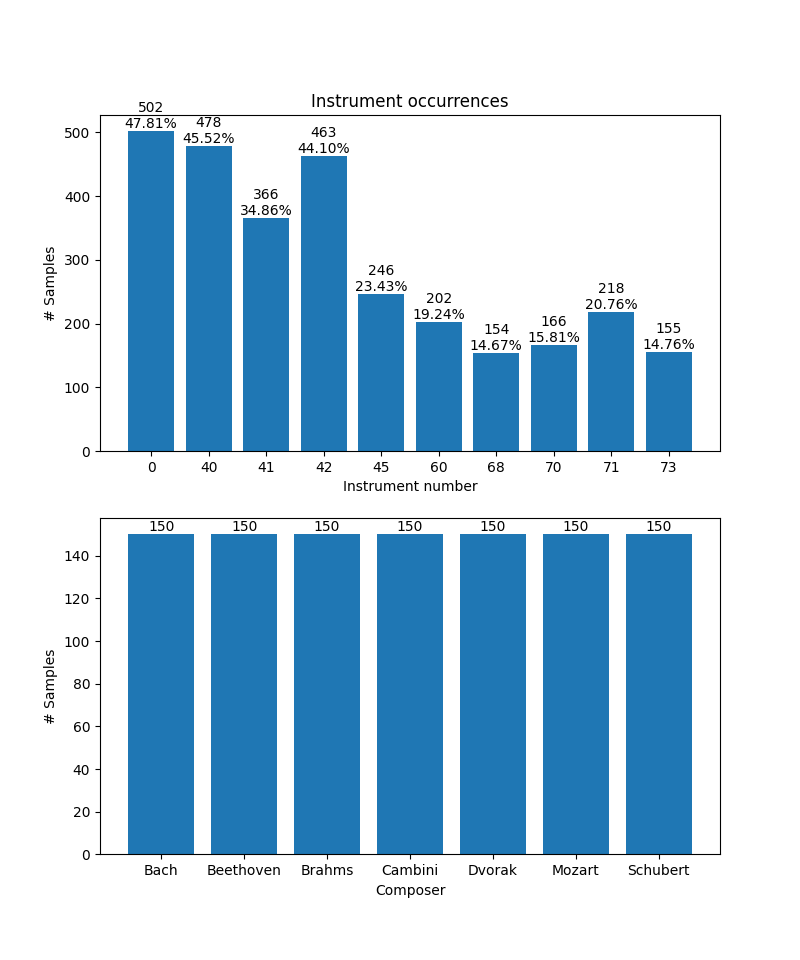

In [31]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)
plt.show()

In [32]:
df.nunique()

composer      7
seconds     238
path        290
0             2
40            2
41            2
42            2
45            2
60            2
68            2
70            2
71            2
73            2
dtype: int64

## Test set

Since the test set from kaggle is small we will ensure the testing set has at least one sample from each class

In [17]:
def modify_test(test_df:pd.DataFrame,train_df:pd.DataFrame,drop_composers,drop_instruments,sample_train=1):
    
    for comp in drop_composers:
        test_df = test_df[test_df["composer"] != comp]
    for inst in drop_instruments:
        test_df = test_df[test_df[inst] != 1]
    test_df = test_df.drop(columns=drop_instruments)


    #Test is quite small so we artificially create more samples by taking away from train
    numerical_cols = np.sort(train_df.columns.difference(FIRST_COLS)).tolist()
    #ensure at least 1 sample from each class
    a = train_df.groupby(numerical_cols,group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    b = train_df.groupby('composer',group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    test_df = pd.concat([test_df,a,b]).drop_duplicates()
    train_df = train_df.drop(pd.concat([a,b]).index)
    return test_df,train_df
    

In [18]:
def load_data():
    
    if os.path.exists(RAW_LABELS_CSV_DIR) == False:
        df = create_dataset(meta)
        df.to_csv(RAW_LABELS_CSV_DIR)
    df = pd.read_csv(RAW_LABELS_CSV_DIR)
    train_df = df[df["train"]==True].drop(columns="train").reset_index(drop=True)
    test_df =  df[df["train"]==False].drop(columns="train").reset_index(drop=True)
    
    train_df = populate_dataset(train_df)
    test_df = populate_dataset(test_df)

    train_df,drop_instruments,drop_composers = remove_outliers(train_df)
    test_df,train_df = modify_test(test_df,train_df,drop_composers,drop_instruments)
    print("Test size:",len(test_df))
    
    
    train_df = drop_excess_samples(train_df)
    print('"Unique" train samples:',len(train_df))
    train_df = balance_composers(train_df)
    print("Total train size:",len(train_df))
    

    le = LabelEncoder()
    train_df["composer"] = le.fit_transform(train_df["composer"])
    test_df["composer"] = le.transform(test_df["composer"])
    return train_df, test_df

train_df,test_df =  load_data()

Test size: 38
"Unique" train samples: 264
Total train size: 1050


In [19]:
def getClasses(df):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    return [[0,1] for i in range(len(numerical_cols)) ], df.composer.unique()

INSTRUMENT_CLASSES, COMPOSER_CLASSES = getClasses(train_df)

# Data loading
Train - Val split

In [24]:
X = train_df.path.to_numpy()
Y = train_df
test_x = test_df.path.to_numpy()
test_y = test_df

train_x, val_x, train_y, val_y = train_test_split(X,Y,test_size=0.2,random_state=42)

In [25]:
train_x.shape, val_x.shape, test_x.shape

((840,), (210,), (38,))

We will be using pytorch's dataloader to load batches of data, for more info go to dataset.py

## Benchmarking

In [26]:
# def mean_time(epoches,loader):
#     total_time = 0
#     total_samples = 0
#     total_batches = 0
#     for i in range(epoches):
#         num_samples = 0
#         num_batches = 0
#         total_epoch_time = 0
#         sample = torch.zeros(1)
#         start = time.time()
#         for s in loader:
#             sample_time = time.time() - start
            
#             sample = s[0]
#             total_epoch_time += sample_time
#             num_samples += len(s[0])
#             num_batches += 1
#             start = time.time()

#         total_batches += num_batches
#         total_samples += num_samples
#         total_time += total_epoch_time

#         avg_batch_time = total_epoch_time/num_batches
#         avg_sample_time = total_epoch_time/num_samples
#         print("Device: {}, Total run time for epoch {}: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(sample.device,i,total_epoch_time,avg_batch_time,avg_sample_time))

#     avg_epoch_time = total_time/epoches
#     avg_sample_time = total_time/total_samples
#     avg_batch_time = total_time/total_batches
#     print("--------------------------------------------------------------------")
#     print("Total run time for {} epoches: {:.3f}, Average epoch time: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(epoches,total_time,avg_epoch_time,avg_batch_time,avg_sample_time))


In [27]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0)
# mean_time(10,train_loader)
# del train_ds
# del train_loader

In [28]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,cache_size=600)
# mean_time(10,train_loader)
# del train_ds
# del train_loader

In [29]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,preload=True)
# mean_time(10,train_loader)
# del train_ds
# del train_loader

In [30]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,preload=True,device=DEVICE)
# mean_time(10,train_loader)
# del train_ds
# del train_loader

In [31]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,preload=True)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=0,preload=True)

In [32]:
a,l1 = train_ds[0]
b,l2 = train_ds[0]
#Each item in the dataloader samples a random section of the audio file. We may get many samples that all match the same label
(a-b).sum(), l1[0] == l2[0], all(l1[1]==l2[1])

(tensor(-0.0647), True, True)

Dataset generator for offline models

In [ ]:
def generate_samples(loader,factor = 1):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    for i in range(factor):
        for x,y in loader:
            samples_x = samples_x + x.tolist()
            samples_y1 = samples_y1 + y[0].tolist()
            samples_y2 = samples_y2 + y[1].tolist()

    return np.array(samples_x), (np.array(samples_y1), np.array(samples_y2))


# Training

For now let's focus on composer only

In [ ]:
#Not many samples at all!!
x,y = generate_samples(train_loader,1)
xVal,yVal = generate_samples(val_loader,1)
x.shape

(840, 40000)

## Offline models (attempt)

- SVC
- KNN
- Adaboost

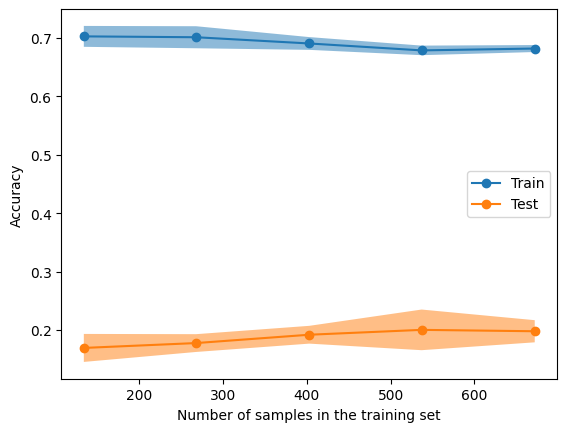

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import LearningCurveDisplay

common_params = {
    "X": x,
    "y": y[0],
    "train_sizes": np.linspace(0.2, 1.0, 5),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

model_svc = SVC(random_state=42,verbose=True)
LearningCurveDisplay.from_estimator(model_svc, **common_params)


Maybe a different model can avoid overfitting?

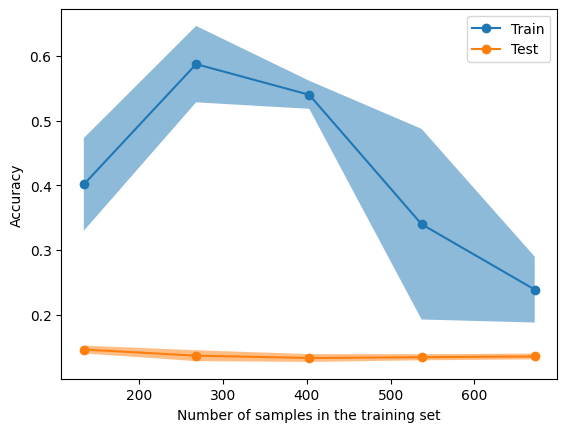

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(3,n_jobs=-1)
LearningCurveDisplay.from_estimator(knn_model, **common_params)


c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=LogisticRegression(n_jobs=-1), n_estimators=100)

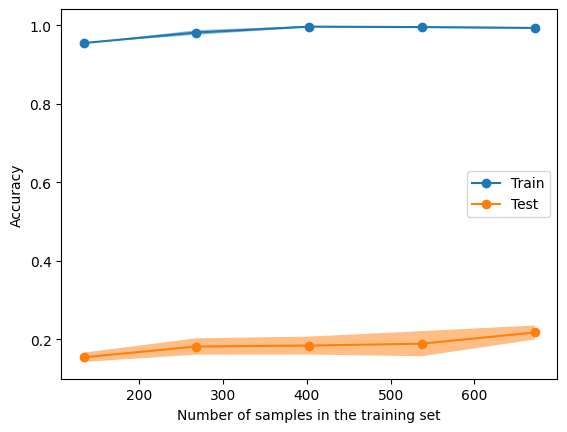

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

weak_model = LogisticRegression(n_jobs = -1)
model_adaboost = AdaBoostClassifier(weak_model,n_estimators=100)
LearningCurveDisplay.from_estimator(model_adaboost, **common_params)
model_adaboost.fit(x,y[0])

In [ ]:
pred = model_adaboost.predict(x)
print(classification_report(y[0],pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       116
           1       1.00      0.97      0.99       118
           2       1.00      0.98      0.99       116
           3       0.98      1.00      0.99       124
           4       1.00      1.00      1.00       119
           5       0.97      1.00      0.98       128
           6       1.00      0.99      1.00       119

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



In [ ]:
pred = model_adaboost.predict(xVal)
print(classification_report(yVal[0],pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.33      0.06      0.11        32
           2       0.19      0.15      0.16        34
           3       0.15      0.12      0.13        26
           4       0.17      0.23      0.19        31
           5       0.16      0.64      0.25        22
           6       0.28      0.23      0.25        31

    accuracy                           0.18       210
   macro avg       0.18      0.20      0.16       210
weighted avg       0.18      0.18      0.15       210



840 samples is clearly not enough...

Warning!! This might be a bad idea... 
```python
x,y = generate_samples(train_loader,100)
```

## Online learning

In [ ]:
def evaluate_models(models:list[SKModel], loader):
    num_correct_1 = np.zeros(len(models))
    num_correct_2 = np.zeros((len(models),len(INSTRUMENT_CLASSES)))
    num_samples = 0
    for _, (x,y) in enumerate(loader):
        for i, model in enumerate(models):
            pred = model.predict(x)
            num_correct_1[i] += np.sum(pred[0]==y[0].numpy())
            num_correct_2[i] += np.sum((pred[1] == y[1].numpy()),axis=0)
        num_samples += len(x)
        
    return num_correct_1/num_samples, num_correct_2/num_samples

def train_loop(models:list[SKModel],train_loader,val_loader,epoches=EPOCHS):
    scores = []
    
    for e in range(epoches):
        if e%5 == 0:
            print('EPOCH %d' % (e))
        start = time.time()
        for _, (x, y) in  enumerate(train_loader):
            for i, model in enumerate(models):
                model.partial_fit(x,y,classes=[COMPOSER_CLASSES,INSTRUMENT_CLASSES])

            
        if e%5 == 0 or e==EPOCHS-1:
            print("epoch time:",time.time()-start)
            acc1,acc2 = evaluate_models(models,train_loader)
            scores.append([acc1,np.mean(acc2,axis=1)])
            for i, model in enumerate(models):
                model_acc2 = ["{:.3%}".format(acc) for acc in acc2[i]]
                print("model {}: train accuracy composer: {:.3%}       train accuracy instrument: ".format(i,acc1[i]),model_acc2)
            
 
    acc1,acc2 = evaluate_models(models,val_loader)
    for i, model in enumerate(models):
        model_acc2 = ["{:.3%}".format(acc) for acc in acc2[i]]
        print("model {}: val accuracy composer: {:.3%}       val accuracy instrument: ".format(i,acc1[i]),model_acc2)

    return models, scores, (acc1, acc2)

In [ ]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier

composer = Perceptron()
instrument = MultiOutputClassifier(Perceptron(), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001)
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)



composer = SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001)
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='hinge',alpha=0.0001)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=0.0001), n_jobs=-1)
model4 = SKModel(composer,instrument,withScalar=True)


models = [model1,model2,model3,model4]

In [ ]:
models, scores, accs = train_loop(models,train_loader,val_loader,epoches=10)

EPOCH 0
epoch time: 13.200459241867065
model 0: train accuracy composer: 16.071%       train accuracy instrument:  ['47.262%', '50.595%', '52.381%', '49.167%', '46.071%', '40.714%', '42.738%', '41.429%', '39.405%', '39.762%']
model 1: train accuracy composer: 19.048%       train accuracy instrument:  ['47.738%', '52.857%', '54.286%', '51.786%', '43.333%', '31.667%', '29.643%', '31.429%', '36.190%', '36.190%']
model 2: train accuracy composer: 18.333%       train accuracy instrument:  ['47.738%', '51.548%', '55.714%', '49.286%', '45.357%', '33.929%', '33.214%', '35.595%', '42.143%', '36.071%']
model 3: train accuracy composer: 17.381%       train accuracy instrument:  ['49.762%', '49.881%', '53.452%', '47.262%', '46.548%', '44.286%', '40.595%', '40.833%', '42.500%', '42.738%']
EPOCH 5
epoch time: 12.839922428131104
model 0: train accuracy composer: 17.024%       train accuracy instrument:  ['54.286%', '50.476%', '53.690%', '52.738%', '54.167%', '50.595%', '51.310%', '49.286%', '48.690%'

Seems like the online models are getting more consistent results... but they are not great...

Maybe the issues are the features themselves?

## Fast Fourier Transform

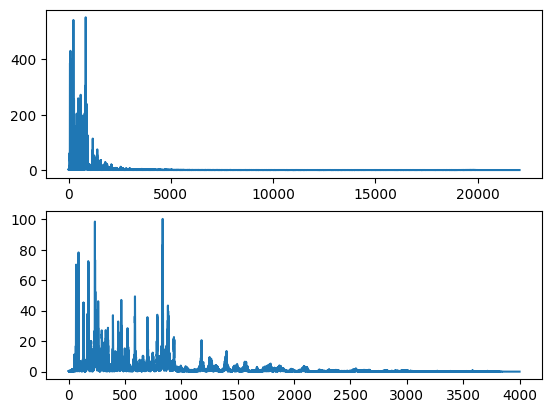

In [ ]:
samples1, sr1 = librosa.load(r'data\musicnet\train_data\1727.wav',sr=None,offset=5,duration=SAMPLE_LENGTH)
samples2, sr2 = librosa.load(r'data\musicnet\train_data\1727.wav',sr=SAMPLING_RATE,offset=5,duration=SAMPLE_LENGTH)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
librosa.display.waveshow(y=samples1,sr=sr1,ax=ax1)
librosa.display.waveshow(y=samples2,sr=sr2,ax=ax2)



Let's try to remove some of the "noise" from the data

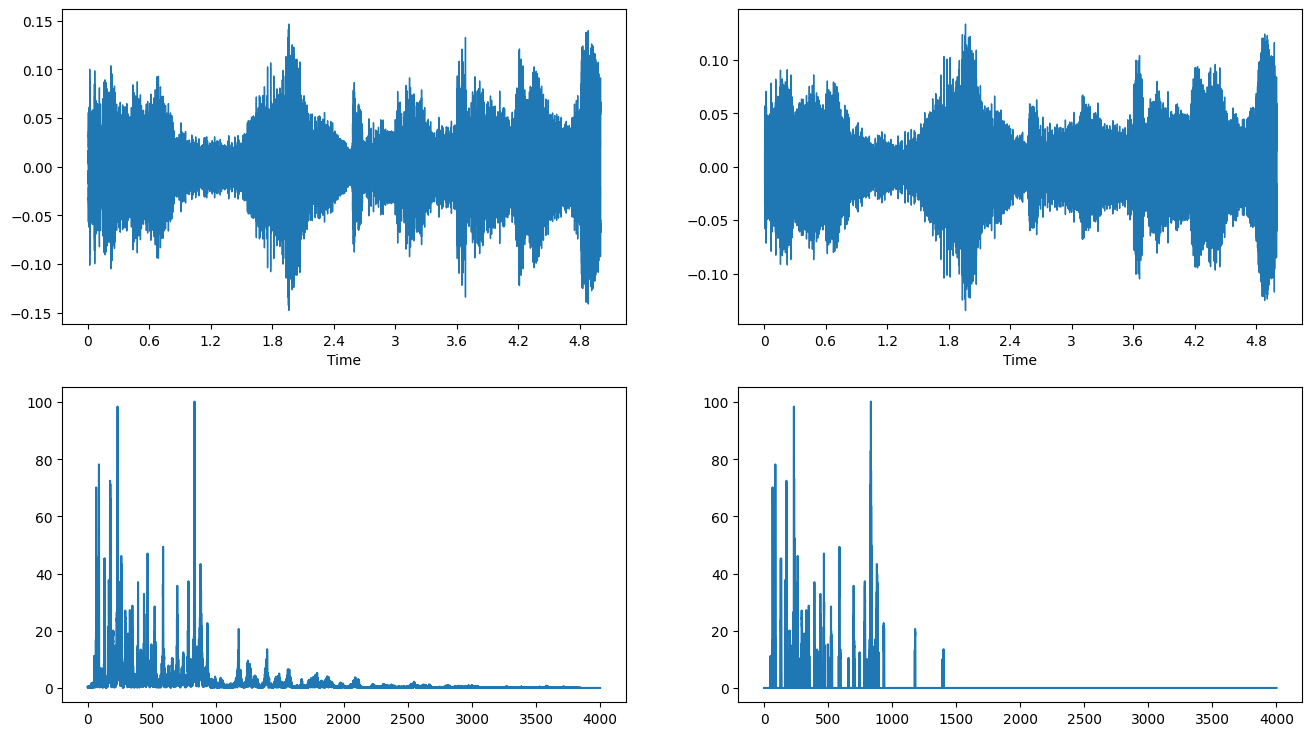

In [ ]:
def plot_fft(sample, sr, ax:plt.Axes):
    y = 1/len(sample) * np.abs(np.fft.fft(sample))[:len(sample)//2]
    y = np.abs(np.fft.fft(sample))[:len(sample)//2]
    x = np.linspace(0.0,sr/2.0,len(sample)//2)
    ax.plot(x,y)

fig, axes = plt.subplots(2,2,figsize=(16,9))
librosa.display.waveshow(y=samples1,sr=sr1,ax=axes[0,0])
librosa.display.waveshow(y=samples2,sr=sr2,ax=axes[0,1])
plot_fft(samples1,sr1,axes[1,0])
plot_fft(samples2,sr2,axes[1,1])


We have amplitude over time in our original data, and the magnitude of each frequency given by FFT, why not use these together?

## Spectogram

<Axes: >

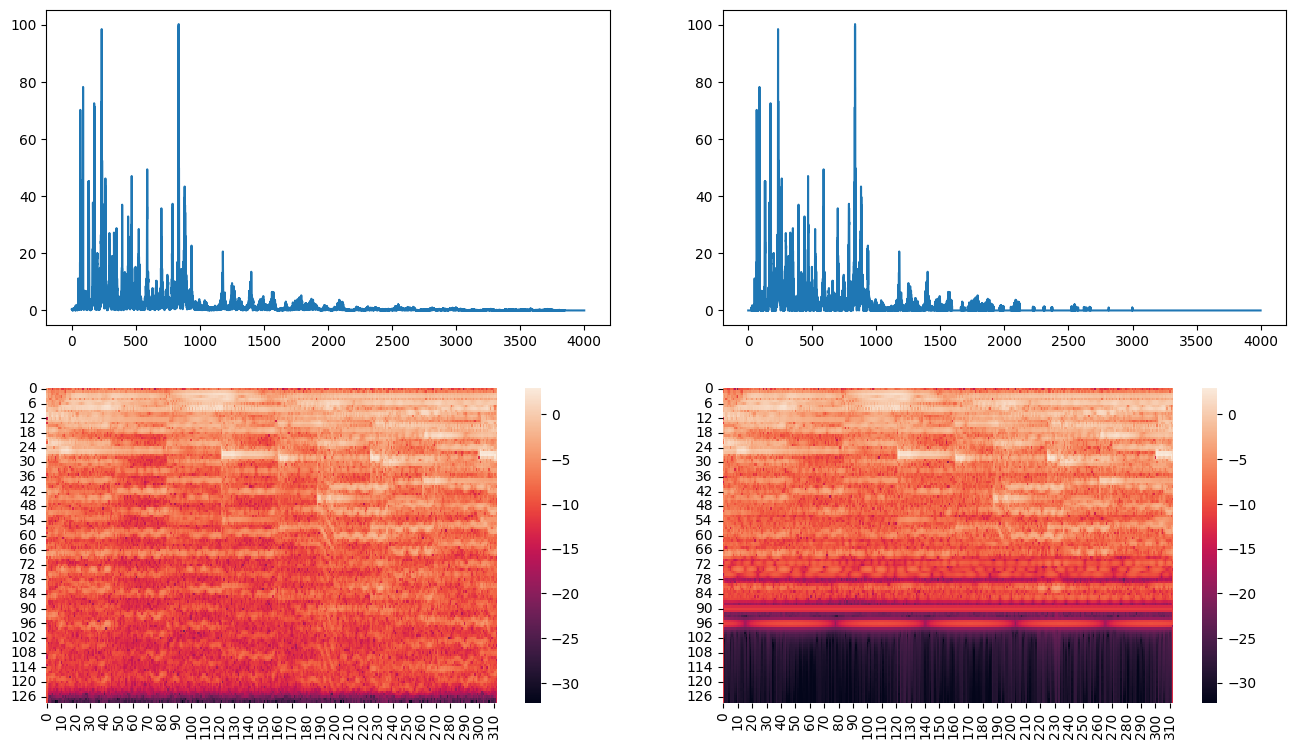

In [ ]:
from Dataset import spectrogram as Dataset_spectogram
import torchvision

fig, axes = plt.subplots(2,2,figsize=(16,9))

newSample = torch.tensor(filter(samples2,0.01))

plot_fft(samples2,sr2,axes[0,0])
plot_fft(newSample,sr2,axes[0,1])


#assuming bpm on average to be around ~120 and no note faster than a 64th-note 
#a note should not be shorter than ~31.25 ms
spec = Dataset_spectogram(torch.tensor(samples2),sr2)

sns.heatmap(spec,ax=axes[1,0])


#remove
newSpec = Dataset_spectogram(newSample,sr2)
sns.heatmap(newSpec,ax=axes[1,1])


## Another attempt

In [ ]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=1,preload=True)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=1,preload=True)
train_ds[0][0].shape

torch.Size([40377])

In [ ]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier

composer = Perceptron()
instrument = MultiOutputClassifier(Perceptron(), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001)
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)



composer = SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001)
instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='hinge',alpha=0.0001)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=0.0001), n_jobs=-1)
model4 = SKModel(composer,instrument,withScalar=True)


models2 = [model1,model2,model3,model4]

In [ ]:
models2, scores, accs = train_loop(models2,train_loader,val_loader,epoches=15)

EPOCH 0
epoch time: 13.834220886230469
model 0: train accuracy composer: 49.524%       train accuracy instrument:  ['67.976%', '88.571%', '82.024%', '89.881%', '63.452%', '70.238%', '75.714%', '67.024%', '72.738%', '75.357%']
model 1: train accuracy composer: 53.214%       train accuracy instrument:  ['82.024%', '95.714%', '81.429%', '92.857%', '69.762%', '78.571%', '77.976%', '79.881%', '85.000%', '79.405%']
model 2: train accuracy composer: 61.429%       train accuracy instrument:  ['79.286%', '92.738%', '85.952%', '91.190%', '73.810%', '77.738%', '75.952%', '77.381%', '78.333%', '75.476%']
model 3: train accuracy composer: 47.262%       train accuracy instrument:  ['77.024%', '94.762%', '72.738%', '91.071%', '66.786%', '64.524%', '73.095%', '64.405%', '79.286%', '76.786%']
EPOCH 5
epoch time: 13.522245645523071
model 0: train accuracy composer: 51.786%       train accuracy instrument:  ['83.333%', '94.524%', '83.571%', '92.619%', '72.619%', '74.167%', '75.000%', '78.929%', '85.595%'

## CNN

We manage to transform our initial audio file into an image, let's try to use a CNN then

In [ ]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,device=DEVICE,cache_size=200)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=2,device=DEVICE,cache_size=100)
train_ds[0][0].shape

torch.Size([1, 128, 312])

In [ ]:
sample = next(iter(train_loader))

In [ ]:
sample[1]

[tensor([5, 4, 1, 1, 6, 6, 5, 6, 6, 5, 4, 0, 6, 5, 3, 1, 3, 6, 2, 5, 1, 5, 5, 1,
         2, 3, 3, 6, 1, 0, 3, 6, 2, 1, 0, 4, 4, 0, 2, 4, 3, 3, 3, 1, 2, 4, 1, 4,
         4, 2, 3, 5, 3, 2, 4, 1, 3, 5, 4, 5, 5, 2, 0, 2], dtype=torch.int32),
 tensor([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 1, 

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import torch


model_composer = nn.Sequential(
    nn.Conv2d(1,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(COMPOSER_CLASSES)),
    
)



model_instruments = nn.Sequential(
    nn.Conv2d(1,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(INSTRUMENT_CLASSES)),
    
)


In [ ]:
opt_composer = torch.optim.Adam(model_composer.parameters(),lr=COMPOSER_LEARNING_RATE,betas=(BETA1,BETA2))
opt_instrument = torch.optim.Adam(model_instruments.parameters(),lr=INSTRUMENT_LEARNING_RATE,betas=(BETA1,BETA2))


In [ ]:
from torch.functional import F
import torch


def check_accuracy(model_composer,model_instruments, data_loader, name=""):
	num_correct_1 = 0
	num_correct_2 = torch.zeros(len(INSTRUMENT_CLASSES),device=DEVICE)
	num_samples = 0
	
	model_composer.eval()  # set model to evaluation mode
	model_instruments.eval()
	
	with torch.no_grad():
		for x, y in data_loader:
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)

			comp_pred = torch.argmax(nn.Softmax(dim=1)(comp_scores),1)
		
			inst_pred = nn.Sigmoid()(inst_scores) > 0.5
			
			num_correct_1 += torch.sum(comp_pred==y1)
			num_correct_2 += torch.sum(inst_pred == (y2>0.5),0)
			num_samples += len(x)
			
	acc1 = num_correct_1/num_samples
	acc2 = num_correct_2/num_samples
	acc2_str = ["{:.3%}".format(acc) for acc in acc2]
	print("{} accuracy composer: {:.3%}       {} accuracy instrument: ".format(name,acc1,name),acc2_str)

		
	return acc1,acc2



def train_nn(model_composer:nn.Sequential, model_instruments:nn.Sequential,
		  loader_train, loader_val,
		  optimizer_comp:torch.optim, optimizer_inst:torch.optim,
		  lossFunction_comp=F.cross_entropy, lossFunction_inst=F.multilabel_soft_margin_loss, 
		  verbose = 0,save_checkpoints=None,eval_every=10):
	
	hist_comp = {"train_loss":[],"train_accuracy":[],"val_accuracy":[]}
	hist_inst= {"train_loss":[],"train_accuracy":[],"val_accuracy":[]}
	model_composer = model_composer.to(device=DEVICE)
	model_instruments = model_instruments.to(device=DEVICE)
	for e in range(EPOCHS):
		if verbose > 0:
			print('EPOCH %d' % (e))
			
		start = time.time()
		for i, (x, y) in enumerate(loader_train):

			model_composer.train()  # put model to training mode
			model_instruments.train()  # put model to training mode
			
			optimizer_comp.zero_grad()
			optimizer_inst.zero_grad()
			
			#x = x.to(device=DEVICE,dtype=torch.float32)  # move to device, e.g. GPU
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			comp_loss = lossFunction_comp(comp_scores,y1)
			inst_loss = lossFunction_inst(inst_scores,y2)

			comp_loss.backward()
			inst_loss.backward()
			
			hist_comp["train_loss"].append(comp_loss.item())
			hist_inst["train_loss"].append(inst_loss.item())

			optimizer_comp.step()
			optimizer_inst.step()
			

		if verbose > 0:
			
			print('composer model loss: = %.4f, instrument model loss:  %.4f' % (comp_loss.item(), inst_loss.item()))
			print("epoch time:",time.time()-start)


		if e%eval_every == 0 and verbose > 1:

			train_acc_comp,train_acc_inst = check_accuracy(model_composer,model_instruments,loader_train,"train")
			val_acc_comp,val_acc_inst = check_accuracy(model_composer,model_instruments,loader_val,"val")
			
			hist_comp["train_accuracy"].append(train_acc_comp)
			hist_comp["val_accuracy"].append(val_acc_comp)

			hist_inst["train_accuracy"].append(train_acc_inst)
			hist_inst["val_accuracy"].append(val_acc_inst)

			if save_checkpoints != None:
				torch.save(model_composer,"checkpoints/composer/"+save_checkpoints+str(e)+".pth")
				torch.save(model_instruments,"checkpoints/instrument/"+save_checkpoints+str(e)+".pth")
		
	train_acc_comp,train_acc_inst = check_accuracy(model_composer,model_instruments,loader_train,"train")
	val_acc_comp,val_acc_inst = check_accuracy(model_composer,model_instruments,loader_val,"val")
	
	hist_comp["train_accuracy"].append(train_acc_comp)
	hist_comp["val_accuracy"].append(val_acc_comp)

	hist_inst["train_accuracy"].append(train_acc_inst)
	hist_inst["val_accuracy"].append(val_acc_inst)

	return hist_comp, hist_inst

In [ ]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,device=DEVICE,cache_size=200)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=2,device=DEVICE,cache_size=100)
train_ds[0][0].shape

torch.Size([1, 128, 312])

In [ ]:
composer_history, instrument_history = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=2,save_checkpoints="first",eval_every=5)

EPOCH 0
composer model loss: = 1.6774, instrument model loss:  0.4025
epoch time: 6.4054999351501465
train accuracy composer: 14.524%       train accuracy instrument:  ['69.524%', '49.524%', '68.571%', '47.738%', '67.381%', '81.667%', '84.881%', '83.571%', '79.524%', '84.524%']
val accuracy composer: 17.143%       val accuracy instrument:  ['68.571%', '50.476%', '66.190%', '48.095%', '68.095%', '86.190%', '87.619%', '86.667%', '83.810%', '87.143%']
EPOCH 1
composer model loss: = 1.2859, instrument model loss:  0.4976
epoch time: 4.045998573303223
EPOCH 2
composer model loss: = 1.0170, instrument model loss:  0.3397
epoch time: 4.083499908447266
EPOCH 3
composer model loss: = 1.5853, instrument model loss:  0.4970
epoch time: 4.017000198364258
EPOCH 4
composer model loss: = 1.4320, instrument model loss:  0.3933
epoch time: 4.573499917984009
EPOCH 5
composer model loss: = 1.2183, instrument model loss:  0.1352
epoch time: 4.360499858856201
train accuracy composer: 57.500%       train ac